# Introduction
Prophet is an open-source tool developed by Facebook specifically designed for forecasting time series data. It is particularly suited for business forecasting problems that have daily observations with seasonality and holidays, which makes it a robust tool for various applications in economics, finance, and business analytics. Prophet is user-friendly and allows users with no deep background in time series analysis to create high-quality forecasts.<br><br>
**NOTE: we will work with store number 4.**

# Import Libraries

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [26]:
!pip install prophet

In [27]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load and Preprocess the Data

In [52]:
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')

/tmp/ipykernel_33/2778724792.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


In [29]:
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

In [30]:
# Set Date as the index
train.set_index('Date', inplace=True)

In [31]:
# Filter data for a specific store 
store_4_data = train[train['Store'] == 4]

In [32]:
# Sort data by date
store_4_data.sort_index(inplace=True)

/tmp/ipykernel_33/2469217681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_4_data.sort_index(inplace=True)


# Train-Test Split

In [33]:
train_size = int(len(store_4_data) * 0.8)
train_data = store_4_data[:train_size].copy(deep=True)
test_data = store_4_data[train_size:].copy(deep=True)

# Define RMSPE function with handling for zero values

In [34]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

# Prophet Model

In [47]:
def prepare_df_prophet(df, Type="train"):
    # Create a deep copy of the dataframe to avoid altering the original data
    new_df = df.copy(deep=True)
    
    # Drop unnecessary columns for the Prophet model
    new_df.drop(["Store", "StateHoliday"], inplace=True, axis=1)
    
    # Extract additional date-related features
    new_df['Day'] = new_df.index.day.astype(int)
    new_df['Month'] = new_df.index.month.astype(int)
    new_df['Year'] = new_df.index.year.astype(int)
    new_df['DayOfYear'] = new_df.index.dayofyear.astype(int)
    new_df['WeekOfYear'] = new_df.index.isocalendar().week.astype(int)
    
    # Reset index to move the 'Date' index into a column
    new_df = new_df.reset_index()
    
    # Rename columns to match Prophet's expected input format
    new_df.rename({"Sales": "y", "Date": "ds"}, axis=1, inplace=True)
    
    # For test data, drop the target variable 'y'
    if Type == "test":
        new_df.drop("y", axis=1, inplace=True)
    
    return new_df

In [42]:
# Prepare training data for Prophet
train_prophet = prepare_df_prophet(store_4_data)

In [43]:
# Initialize Prophet model
Prophet_model = Prophet()

# List of additional regressors to be added to the Prophet model
regressors = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

# Add each regressor to the Prophet model
for regressor in regressors:
    Prophet_model.add_regressor(regressor)

In [44]:
# Fit the Prophet model with the prepared training data
Prophet_model.fit(train_prophet)

11:31:43 - cmdstanpy - INFO - Chain [1] start processing
11:31:43 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Prepare the test data for Prophet model
test_prophet = prepare_df_prophet(test_data, Type="test")

In [48]:
# Make future dataframe for prediction, aligning with the test data
future = test_prophet.drop(columns=['ds'])

# Use the fitted Prophet model to make predictions
prophet_preds = Prophet_model.predict(test_prophet)

# Extract only the predicted 'yhat' values
prophet_preds = prophet_preds['yhat']

In [49]:
# Calculate RMSPE for the Prophet model on the test data
prophet_rmspe = rmspe(test_data['Sales'], prophet_preds)

# Print the RMSPE result
print(f'RMSPE for Prophet on Test: {prophet_rmspe}')

RMSPE for Prophet on Test: 0.14468043678929382


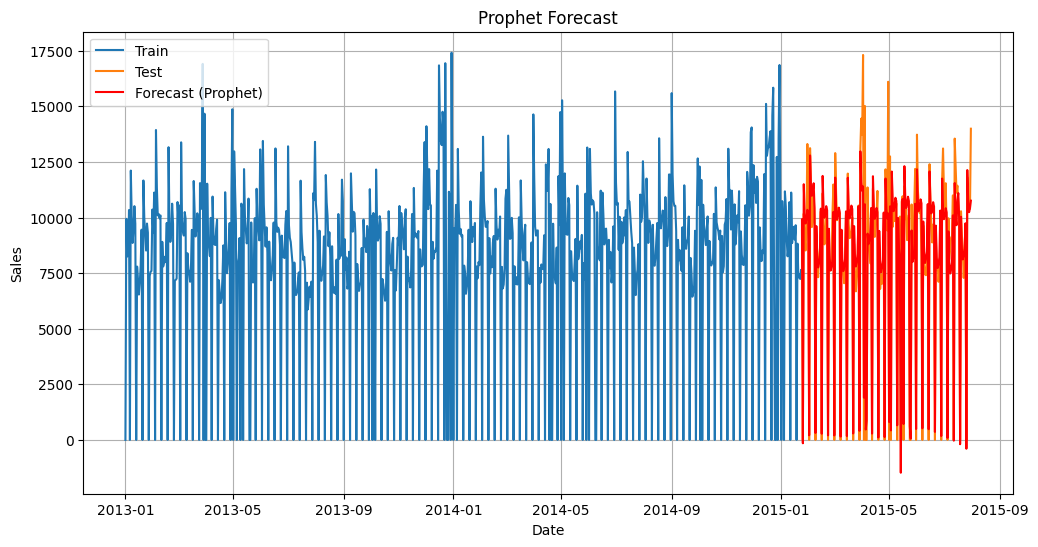

In [51]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(test_data.index, prophet_preds, label='Forecast (Prophet)', color='red')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()